## **Data Load**

In [1]:
# import all library
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import timeit
import tracemalloc

In [2]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


## **Q2. Incremental PCA**

creating subdatasets

In [31]:
x_sub1, x_sub2, x_sub3, x_sub4 = [], [], [], []
y_sub1, y_sub2, y_sub3, y_sub4 = [], [], [], []

n_classes = 52
images_per_class = 8

for i in range(n_classes):
  x_sub1.append(x_train[:,i*images_per_class :i*images_per_class + 2])
  x_sub2.append(x_train[:,i*images_per_class+2 :i*images_per_class + 4])
  x_sub3.append(x_train[:,i*images_per_class+4 :i*images_per_class + 6])
  x_sub4.append(x_train[:,i*images_per_class+6 :i*images_per_class + 8])

  y_sub1.append(y_train[:,i*images_per_class :i*images_per_class + 2])
  y_sub2.append(y_train[:,i*images_per_class+2 :i*images_per_class + 4])
  y_sub3.append(y_train[:,i*images_per_class+4 :i*images_per_class + 6])
  y_sub4.append(y_train[:,i*images_per_class+6 :i*images_per_class + 8])

x_sub1, x_sub2, x_sub3, x_sub4 = np.hstack(x_sub1), np.hstack(x_sub2), np.hstack(x_sub3), np.hstack(x_sub4)
y_sub1, y_sub2, y_sub3, y_sub4 = np.hstack(y_sub1), np.hstack(y_sub2), np.hstack(y_sub3), np.hstack(y_sub4)

x_subs = [x_sub1, x_sub2, x_sub3, x_sub4]
y_subs = [y_sub1, y_sub2, y_sub3, y_sub4]

1. Incremental learning

In [32]:
import time

def ipca_nn(n_components, x_subs, y_subs, x_test):
  # Measure memory usage and execution time

    ipca = IncrementalPCA(n_components = n_components)

    run_time = 0
     
    tracemalloc.start() 
    for subset in x_subs:
        start_time = time.perf_counter()

        ipca.partial_fit(subset.T)

        end_time = time.perf_counter()
        run_time += end_time - start_time

    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Project train data
    W_train = np.vstack([ipca.transform(subset.T) for subset in x_subs])

    # Train NN model
    nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
    y_train_combined = np.concatenate([y_subs[0].T, y_subs[1].T, y_subs[2].T, y_subs[3].T])
    nn.fit(W_train, y_train_combined.ravel())

    # Project test data and predict
    W_test = ipca.transform(x_test.T).T
    y_pred = nn.predict(W_test.T)

    return y_pred, run_time, peak_memory

ipca_y_pred, ipca_run_time, ipca_peak_memory = ipca_nn(20, x_subs, y_subs, x_test)

accuracy = accuracy_score(y_test.T, ipca_y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Peak memory usage: {ipca_peak_memory / 10**6} MB")
print(f"Execution Time: {ipca_run_time:.8f} seconds")

Accuracy: 57.69%
Peak memory usage: 13.132397 MB
Execution Time: 0.14313459 seconds


In [33]:
# def ipca_nn(n_components, x_subs, y_subs, x_test):
#   # Measure memory usage and execution time
#   tracemalloc.start() 
#   start_time = timeit.default_timer()  # Start timing

#   ipca = IncrementalPCA(n_components = n_components)
  
#   for subset in x_subs:
#     ipca.partial_fit(subset.T)

#   current_memory, peak_memory = tracemalloc.get_traced_memory()
#   tracemalloc.stop()
#   end_time = timeit.default_timer()  # Stop timing
#   run_time = end_time - start_time
  
#   # Project train data
#   W_train_sub1 = ipca.transform(x_subs[0].T).T
#   W_train_sub2 = ipca.transform(x_subs[1].T).T
#   W_train_sub3 = ipca.transform(x_subs[2].T).T
#   W_train_sub4 = ipca.transform(x_subs[3].T).T
#   W_train = np.vstack((W_train_sub1.T, W_train_sub2.T, W_train_sub3.T, W_train_sub4.T))

#   # Train NN model
#   nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
#   y_train_combined = np.concatenate([y_subs[0].T, y_subs[1].T, y_subs[2].T, y_subs[3].T])
#   nn.fit(W_train, y_train_combined.ravel())

#   # Project test data and predict
#   W_test = ipca.transform(x_test.T).T
#   y_pred = nn.predict(W_test.T)

#   return y_pred, run_time, current_memory, peak_memory

# ipca_y_pred, ipca_run_time, ipca_current_memory, ipca_peak_memory = ipca_nn(20, x_subs, y_subs, x_test)

# accuracy = accuracy_score(y_test.T, ipca_y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")
# print(f"Current memory usage: {ipca_current_memory / 10**6} MB")
# print(f"Peak memory usage: {ipca_peak_memory / 10**6} MB")
# print(f"Execution Time: {ipca_run_time:.8f} seconds")

Define pca and nn classifier

In [34]:
def pca_nn(n_components, x_train, y_train, x_test):
  # Measure memory usage and execution time
  tracemalloc.start() 
  start_time = time.perf_counter()

  pca = PCA(n_components = n_components)
  pca.fit(x_train.T)

  current_memory, peak_memory = tracemalloc.get_traced_memory()
  tracemalloc.stop()
  end_time = time.perf_counter()

  run_time = end_time - start_time

  # Project train data
  W_train = pca.transform(x_train.T).T

  # Train NN model
  nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
  nn.fit(W_train.T, y_train.reshape(-1))

  # Project test data and predict
  W_test = pca.transform(x_test.T).T
  y_pred = nn.predict(W_test.T)

  return y_pred, run_time, peak_memory

2. Batch PCA

In [258]:
batch_y_pred, batch_run_time, batch_peak_memory = pca_nn(30, x_train, y_train, x_test)

accuracy = accuracy_score(y_test.T, batch_y_pred)
print(f"Accuracy : {accuracy * 100:.2f}%")
print(f"Peak memory usage: {batch_peak_memory / 10**6} MB")
print(f"Execution Time: {batch_run_time:.8f} seconds")

Accuracy : 63.46%
Peak memory usage: 11.237481 MB
Execution Time: 0.08696950 seconds


3. PCA with first train subset

In [338]:
# Input of pca_nn: x_sub1
sub1_y_pred, sub1_run_time, sub1_peak_memory = pca_nn(15, x_sub1, y_sub1, x_test)

accuracy = accuracy_score(y_test.T, sub1_y_pred)
print(f"Accuracy : {accuracy * 100:.2f}%")
print(f"Peak memory usage: {sub1_peak_memory / 10**6} MB")
print(f"Execution Time: {sub1_run_time:.8f} seconds")

Accuracy : 25.00%
Peak memory usage: 3.757625 MB
Execution Time: 0.01700096 seconds


Show result

In [37]:
# Get Average Result
def avg_results(num_iter, func, num_bases, x_train, y_train, x_test, y_test):
    accuracy_avg, run_time_avg, peak_memory_avg = 0,0,0

    for i in range(num_iter):
        y_pred, run_time, peak_memory = func(num_bases, x_train, y_train, x_test)
        accuracy = accuracy_score(y_test.T, y_pred) * 100
        
        accuracy_avg += accuracy
        run_time_avg += run_time
        peak_memory_avg += peak_memory
    
    accuracy_avg /= num_iter
    run_time_avg /= num_iter
    peak_memory_avg /= num_iter

    return accuracy_avg, run_time_avg,  peak_memory_avg

In [38]:
num_base_vecs = []

ipca_acc_result = []
batch_acc_result = []
sub1_acc_result = []

ipca_runtime_result = []
batch_runtime_result = []
sub1_runtime_result = []

ipca_peak_mem_result = []
batch_peak_mem_result = []
sub1_peak_mem_result = []


for i in range(1, 11):
    num_bases = 5*i
    num_base_vecs.append(num_bases)
    
    # Get each PCA result
    ipca_accuracy, ipca_run_time, ipca_peak_memory = avg_results(10, ipca_nn, num_bases, x_subs, y_subs, x_test, y_test)
    batch_accuracy, batch_run_time, batch_peak_memory = avg_results(10, pca_nn, num_bases, x_train, y_train, x_test, y_test)
    sub1_accuracy, sub1_run_time, sub1_peak_memory = avg_results(10, pca_nn, num_bases, x_sub1, y_sub1, x_test, y_test)

    # accuracy arrays
    ipca_acc_result.append(ipca_accuracy)
    batch_acc_result.append(batch_accuracy)
    sub1_acc_result.append(sub1_accuracy)

    # runtime arrays -> seconds
    ipca_runtime_result.append(ipca_run_time)
    batch_runtime_result.append(batch_run_time)
    sub1_runtime_result.append(sub1_run_time)
    

    # peak memory arrays -> Mega Bite (MB)
    ipca_peak_mem_result.append(ipca_peak_memory / 10**6)
    batch_peak_mem_result.append(batch_peak_memory / 10**6)
    sub1_peak_mem_result.append(sub1_peak_memory / 10**6)

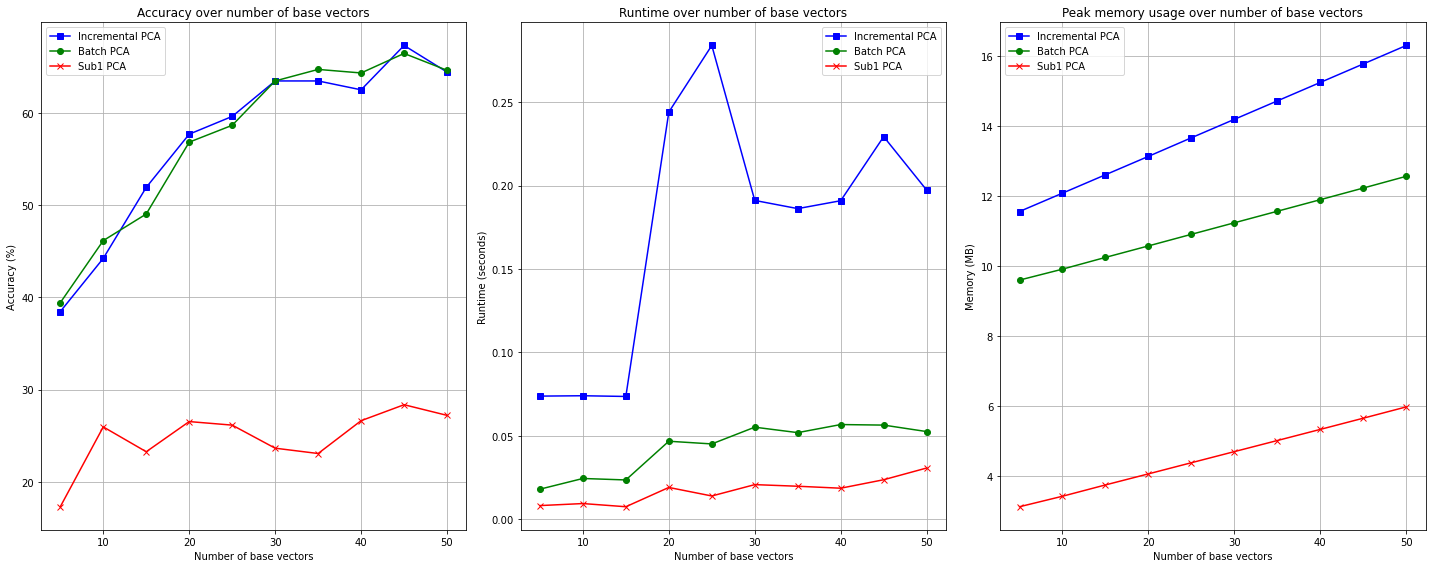

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot accuracy on the first subplot
axes[0].plot(num_base_vecs, ipca_acc_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[0].plot(num_base_vecs, batch_acc_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[0].plot(num_base_vecs, sub1_acc_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[0].set_xlabel('Number of base vectors')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy over number of base vectors')
axes[0].legend()
axes[0].grid(True)

# Plot runtime on the second subplot
axes[1].plot(num_base_vecs, ipca_runtime_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[1].plot(num_base_vecs, batch_runtime_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[1].plot(num_base_vecs, sub1_runtime_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[1].set_xlabel('Number of base vectors')
axes[1].set_ylabel('Runtime (seconds)')  # Customize based on your runtime units
axes[1].set_title('Runtime over number of base vectors')
axes[1].legend()
axes[1].grid(True)

# Plot Peak memory usage on third subplot
axes[2].plot(num_base_vecs, ipca_peak_mem_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[2].plot(num_base_vecs, batch_peak_mem_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[2].plot(num_base_vecs, sub1_peak_mem_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[2].set_xlabel('Number of base vectors')
axes[2].set_ylabel('Memory (MB)')  # Customize based on your runtime units
axes[2].set_title('Peak memory usage over number of base vectors')
axes[2].legend()
axes[2].grid(True)

# Display the combined plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Check for large datasize

In [71]:
import numpy as np
from sklearn.decomposition import PCA, IncrementalPCA
import time
import matplotlib.pyplot as plt

# Parameters
data_sizes = [10000, 20000, 30000, 40000, 50000, 100000]
n_features = 50
n_components = 10
batch_size = 10000

runtime_batch_pca = []
runtime_incremental_pca = []
peak_memory_batch = []
peak_memory_ipca = []

for size in data_sizes:
    data = np.random.rand(size, n_features)
    
    # Measure runtime for Batch PCA
    tracemalloc.start()
    start_time = time.process_time()
    
    pca = PCA(n_components=n_components)
    pca.fit(data)

    current_memory, peak_memory = tracemalloc.get_traced_memory()
    runtime_batch_pca.append(time.process_time() - start_time)
    tracemalloc.stop()
    peak_memory_batch.append(peak_memory/(1024**2))
    
    tracemalloc.start()
    start_time = time.process_time()
    inc_pca = IncrementalPCA(n_components=n_components)
    for start in range(0, size, batch_size):
        end = min(start + batch_size, size)
        inc_pca.partial_fit(data[start:end])
    runtime_incremental_pca.append(time.process_time() - start_time)
    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_memory_ipca.append(peak_memory/(1024**2))

    print(f"Data Size: {size}, Batch PCA Time: {runtime_batch_pca[-1]:.2f} sec, Incremental PCA Time: {runtime_incremental_pca[-1]:.2f} sec")


Data Size: 10000, Batch PCA Time: 0.15 sec, Incremental PCA Time: 0.09 sec
Data Size: 20000, Batch PCA Time: 0.30 sec, Incremental PCA Time: 0.24 sec
Data Size: 30000, Batch PCA Time: 0.44 sec, Incremental PCA Time: 0.34 sec
Data Size: 40000, Batch PCA Time: 0.62 sec, Incremental PCA Time: 0.46 sec
Data Size: 50000, Batch PCA Time: 0.76 sec, Incremental PCA Time: 0.55 sec
Data Size: 100000, Batch PCA Time: 1.41 sec, Incremental PCA Time: 1.34 sec


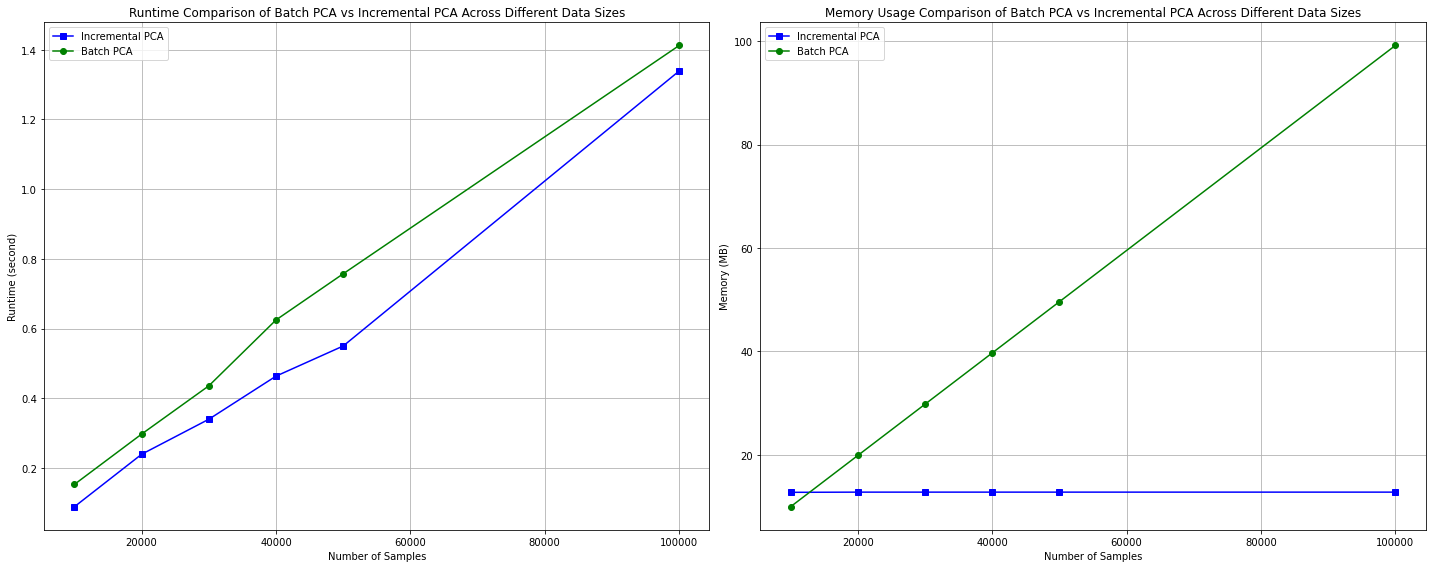

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(data_sizes, runtime_incremental_pca, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[0].plot(data_sizes, runtime_batch_pca, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[0].set_xlabel('Number of Samples')
axes[0].set_ylabel('Runtime (second)')
axes[0].set_title("Runtime Comparison of Batch PCA vs Incremental PCA Across Different Data Sizes")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(data_sizes, peak_memory_ipca, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[1].plot(data_sizes, peak_memory_batch, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Memory (MB)')
axes[1].set_title("Memory Usage Comparison of Batch PCA vs Incremental PCA Across Different Data Sizes")
axes[1].legend()
axes[1].grid(True)

# Display the combined plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [151]:
def pca_iter_time(n_components, x_subs):
  # Measure memory usage and execution time

    pca = PCA(n_components = n_components)

    run_time = 0
    tracemalloc.start() 
    for subset in x_subs:
        start_time = time.process_time()

        pca.fit(subset.T)

        end_time = time.process_time()
        run_time += end_time - start_time

    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return run_time, peak_memory

run_time, memory = pca_iter_time(50, x_subs)

print(f"Peak memory usage: {memory / 10**6} MB")
print(f"Execution Time: {run_time:.8f} seconds")

Peak memory usage: 7.221166 MB
Execution Time: 0.99721800 seconds


In [152]:
def pca_time(n_components, x_train):
    pca = PCA(n_components = n_components)

    run_time = 0
    tracemalloc.start()
    start_time = time.process_time()

    pca.fit(x_train.T)

    end_time = time.process_time()
    run_time += end_time - start_time

    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return run_time, peak_memory

run_time, memory = pca_time(50, x_train)

print(f"Peak memory usage: {memory / 10**6} MB")
print(f"Execution Time: {run_time:.8f} seconds")

Peak memory usage: 12.563586 MB
Execution Time: 0.60175700 seconds


Reconstruction Error

In [160]:
def pca_recon_error(n_components, x_train, x_test):
  pca = PCA(n_components = n_components)
  pca.fit(x_train.T)

  W_test = pca.transform(x_test.T).T
  test_recon = pca.inverse_transform(W_test.T).T

  rec_err = np.mean(np.abs(x_test - test_recon))

  return rec_err

def ipca_recon_error(n_components, x_subs, x_test):
  ipca = IncrementalPCA(n_components = n_components)
  for subset in x_subs:
      ipca.partial_fit(subset.T)

  W_test = ipca.transform(x_test.T).T
  test_recon = ipca.inverse_transform(W_test.T).T

  rec_err = np.mean(np.abs(x_test - test_recon))

  return rec_err

num_bases = 15

ipca_rec_err = ipca_recon_error(num_bases, x_subs, x_test)
batch_rec_err = pca_recon_error(num_bases, x_train, x_test)
sub1_rec_err = pca_recon_error(num_bases, x_sub1, x_test)


print(f"Reconstruction Error of Incremental PCA with {num_bases} base eigenvectors (MAE): {ipca_rec_err:.3f}")
print(f"Reconstruction Error of Batch PCA with {num_bases} base eigenvectors (MAE): {batch_rec_err:.3f}")
print(f"Reconstruction Error of Sub1 PCA with {num_bases} base eigenvectors (MAE): {sub1_rec_err:.3f}")

Reconstruction Error of Incremental PCA with 15 base eigenvectors (MAE): 16.125
Reconstruction Error of Batch PCA with 15 base eigenvectors (MAE): 16.024
Reconstruction Error of Sub1 PCA with 15 base eigenvectors (MAE): 19.380


Method in the lecture

In [324]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import orth

# Step 1: Perform PCA on the original and new data separately
pca1 = PCA(n_components=30)
pca2 = PCA(n_components=30)
pca3 = PCA(n_components=30)
pca4 = PCA(n_components=30)

P1 = pca1.fit(x_sub1.T).components_.T
P2 = pca2.fit(x_sub2.T).components_.T
P3 = pca3.fit(x_sub3.T).components_.T
P4 = pca4.fit(x_sub4.T).components_.T

# Step 1: Stack P1 and P2 column-wise to form the combined matrix
combined_matrix = np.hstack((P1, P2))
Phi = orth(combined_matrix) 
overlap_matrix = np.dot(P1.T, Phi)
U, _, Vt = np.linalg.svd(overlap_matrix)
min_dim = min(U.shape[1], Vt.shape[0])
U = U[:, :min_dim]
Vt = Vt[:min_dim, :]
R = np.dot(U, Vt)
P_new = np.dot(Phi, R.T)

combined_matrix = np.hstack((P_new, P3))
Phi = orth(combined_matrix) 
overlap_matrix = np.dot(P_new.T, Phi)
U, _, Vt = np.linalg.svd(overlap_matrix)
min_dim = min(U.shape[1], Vt.shape[0])
U = U[:, :min_dim]
Vt = Vt[:min_dim, :]
R = np.dot(U, Vt)
P_new = np.dot(Phi, R.T)

combined_matrix = np.hstack((P_new, P4))
Phi = orth(combined_matrix) 
overlap_matrix = np.dot(P_new.T, Phi)
U, _, Vt = np.linalg.svd(overlap_matrix)
min_dim = min(U.shape[1], Vt.shape[0])
U = U[:, :min_dim]
Vt = Vt[:min_dim, :]
R = np.dot(U, Vt)
P_new = np.dot(Phi, R.T)

P_new.shape


(2576, 30)

In [331]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import orth

# Step 1: Perform PCA on the original and new data separately
pca1 = PCA(n_components=10)
pca2 = PCA(n_components=10)
pca3 = PCA(n_components=10)
pca4 = PCA(n_components=10)

P1 = pca1.fit(x_sub1.T).components_.T
P2 = pca2.fit(x_sub2.T).components_.T
P3 = pca3.fit(x_sub3.T).components_.T
P4 = pca4.fit(x_sub4.T).components_.T

# Step 1: Stack P1 and P2 column-wise to form the combined matrix
combined_matrix = np.hstack((P1, P2))
Phi = orth(combined_matrix) 
P_new = Phi[:, :30]

combined_matrix = np.hstack((P_new, P3))
Phi = orth(combined_matrix) 
P_new = Phi[:, :30]

combined_matrix = np.hstack((P_new, P4))
Phi = orth(combined_matrix) 
P_new = Phi[:, :30]

P_new.shape


(2576, 30)

In [332]:
x_train_bar = np.average(x_train, axis=1).reshape(-1,1)

A_test = x_test - x_train_bar
W_test = np.matmul(P_new.T, A_test)
x_test_rec = x_train_bar + np.matmul(P_new, W_test)

rec_err = np.mean(np.abs(x_test - x_test_rec))
print(f"Reconstruction Error with eigenvectors (MAE): {rec_err}")

Reconstruction Error with eigenvectors (MAE): 15.55205629573753


In [340]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define the 1-Nearest Neighbor classifier with L1 distance (Manhattan distance)
nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

# projection of training images
x_train_proj = np.matmul(P_new.T, x_train - x_train_bar)
x_test_proj = np.matmul(P_new.T, x_test - x_train_bar)

nn.fit(x_train_proj.T, y_train.reshape(-1))

# Model prediction
y_pred = nn.predict(x_test_proj.T)


# Calculate Accuracy
accuracy = accuracy_score(y_test.T, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 57.69%


In [341]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define the 1-Nearest Neighbor classifier with L1 distance (Manhattan distance)
nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

# projection of training images
x_train_proj = np.matmul(P1.T, x_train - x_train_bar)
x_test_proj = np.matmul(P1.T, x_test - x_train_bar)

nn.fit(x_train_proj.T, y_train.reshape(-1))

# Model prediction
y_pred = nn.predict(x_test_proj.T)


# Calculate Accuracy
accuracy = accuracy_score(y_test.T, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 50.96%
